In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from PD_freqitems import freqitemsets
from pyfim import pyeclat

In [10]:
#Read product names and IDs
lines=open("products.txt", "rt", encoding="utf8").readlines()
products=[0]*len(lines)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid)]=pname

del products[0] #the products list contains a 0 as the first element
#products

In [11]:
#read transactions
orders=pickle.load(open("order_products.pickle", "rb"))
#orders

In [12]:
#check products on order 2:
#for prod in orders[2]: print(products[prod])

In [13]:
# Convert the transaction data into a list of lists
orders_list = [list(order) for order in orders.values()]
#orders_list

In [14]:
# Encode the transaction data as a binary matrix
te = TransactionEncoder()
te_ary = te.fit_transform(orders_list, sparse=True)

df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
#df

In [15]:
# Create a dictionary to map product IDs to names
id_to_name = {i: products[i] for i in range(len(products))}

# Rename the columns using the ID-to-name dictionary
df = df.rename(columns=id_to_name)
#df

In [16]:
# Remove the last column of the dataframe (for some reason it has a product with no identifiable name - 49688)
df = df.drop(df.columns[-1], axis=1)
df

,All-Seasons Salt,Robust Golden Unsweetened Oolong Tea,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,Green Chile Anytime Sauce,Dry Nose Oil,Pure Coconut Water With Orange,Cut Russet Potatoes Steam N' Mash,Light Strawberry Blueberry Yogurt,Sparkling Orange Juice & Prickly Pear Beverage,Peach Mango Juice,...,Famous Chocolate Wafers,All Natural Creamy Caesar Dressing,Spaghetti with Meatballs and Sauce Meal,California Limeade,Cucumber Kirby,"""Vodka, Triple Distilled, Twist of Vanilla""",En Croute Roast Hazelnut Cranberry,Artisan Baguette,Smartblend Healthy Metabolism Dry Cat Food,Fresh Foaming Cleanser
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3214870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3214871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3214872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
with open('transactions.dat', 'w') as file:
    for transaction in orders_list:
        transaction_str = ' '.join(str(product_id) for product_id in transaction)
        file.write(transaction_str + '\n')
        
def load_transactions(file_name, sep=","):
#input: csv file with one transaction per line,
#           where transactions may have a different number of items
#    output: matrix where each row is a vector of items (transaction)
    lines = open(file_name, 'rt').readlines()
    transactions_matrix = []
    for l in lines:
        l = l.rstrip('\n')
        transaction = l.split(sep)
        transactions_matrix.append(transaction)
    return transactions_matrix

transactions = load_transactions("transactions.dat", sep=" ")

In [18]:
tr_enc = TransactionEncoder()
trans_array = tr_enc.fit_transform(transactions, sparse=True)
trans_database = pd.DataFrame.sparse.from_spmatrix(trans_array, columns=tr_enc.columns_)

In [22]:
D={"threshold": [0.2, 0.1, 0.05, 0.02, 0.01], 
   "num_itemsets":[],
   "apriori":[], 
   "FP-growth":[], 
   "ECLAT":[], 
   "PD":[]}

for min_supp in D["threshold"]:
    t0 = time.time()
    FI_apriori=apriori(df, min_supp)
    t1 = time.time()
    D["num_itemsets"].append(FI_apriori.shape[0])
    D["apriori"].append(t1-t0)

    FI_fpg= fpgrowth(df, min_supp)
    t2 = time.time()
    D["FP-growth"].append(t2-t1)

    FI_eclat= pyeclat(trans_database, min_supp)    
    t3 = time.time()
    D["ECLAT"].append(t3-t2)

    FI_pdfis= freqitemsets(trans_database, min_supp)    
    t4 = time.time()
    D["PD"].append(t4-t3)

    
    print(min_supp, FI_apriori.shape[0],"\n\tApriori time:", t1-t0, 
          "\n\tFP-growth time:",t2-t1,
          "\n\tECLAT time:", t3-t2,
          "\n\tPD time:", t4-t3)
    

df_performance=pd.DataFrame(D)
df_performance

0.2 0 
	Apriori time: 3.3039472103118896 
	FP-growth time: 28.24538540840149 
	ECLAT time: 0.3604164123535156 
	PD time: 0.2435145378112793
0.1 2 
	Apriori time: 3.2925610542297363 
	FP-growth time: 29.760762453079224 
	ECLAT time: 0.17267799377441406 
	PD time: 0.2510490417480469
0.05 6 
	Apriori time: 3.7798140048980713 
	FP-growth time: 31.53386878967285 
	ECLAT time: 0.15338134765625 
	PD time: 0.22484731674194336
0.02 39 
	Apriori time: 72.93805146217346 
	FP-growth time: 53.32008242607117 
	ECLAT time: 1.475386619567871 
	PD time: 0.26575422286987305


C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other


0.01 102 
	Apriori time: 313.0657796859741 
	FP-growth time: 227.3599762916565 
	ECLAT time: 0.17705130577087402 
	PD time: 0.2934448719024658


,threshold,num_itemsets,apriori,FP-growth,ECLAT,PD
0,0.20,0,3.303947,28.245385,0.360416,0.243515
1,0.10,2,3.292561,29.760762,0.172678,0.251049
2,0.05,6,3.779814,31.533869,0.153381,0.224847
3,0.02,39,72.938051,53.320082,1.475387,0.265754
4,0.01,102,313.065780,227.359976,0.177051,0.293445


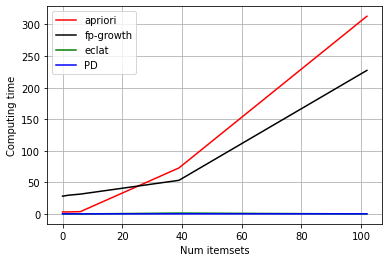

In [28]:
plt.plot(df_performance["num_itemsets"], df_performance["apriori"], c='r', label='apriori')
plt.plot(df_performance["num_itemsets"], df_performance["FP-growth"], c='k', label='fp-growth')
plt.plot(df_performance["num_itemsets"], df_performance["ECLAT"], c='g', label='eclat')
plt.plot(df_performance["num_itemsets"], df_performance["PD"], c='b', label='PD')
plt.xlabel("Num itemsets")
plt.ylabel("Computing time")
plt.grid()
plt.legend()
plt.show()

C:\Users\dgonc\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dgonc\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dgonc\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dgonc\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


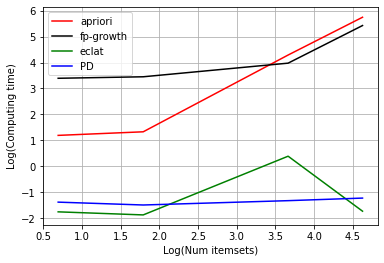

In [29]:
plt.plot(np.log(df_performance["num_itemsets"]), np.log(df_performance["apriori"]), c='r', label='apriori')
plt.plot(np.log(df_performance["num_itemsets"]), np.log(df_performance["FP-growth"]), c='k', label='fp-growth')
plt.plot(np.log(df_performance["num_itemsets"]), np.log(df_performance["ECLAT"]), c='g', label='eclat')
plt.plot(np.log(df_performance["num_itemsets"]), np.log(df_performance["PD"]), c='b', label='PD')
plt.xlabel("Log(Num itemsets)")
plt.ylabel("Log(Computing time)")
plt.grid()
plt.legend()
plt.show()

ECLAT and the recursive algorithm (PD) perform better than the other ones. At the lowest threshold considered (0.01), ECLAT is the best one by a small margin.

#we could try lowering the threshold further, though it doesn't seem the results will change much

In [31]:
FI_freqitems = freqitemsets(trans_database, 0.01)
FI_freqitems 

#it doesn't print any itemsets, not even for support = 0.2, idky :( 
#but we can always continue our analysis with ECLAT (see below)

,support,itemsets


In [25]:
pd.set_option('display.max_rows', None)
FI_eclat= pyeclat(trans_database, 0.01) #they all range from 0 to 9 only... is this correct? :/
FI_eclat

,support,itemsets
0,0.019063,"(0, 9, 7)"
1,0.019063,"(0, 9, 8)"
2,0.019385,"(0, 9, 5)"
3,0.019385,"(0, 9, 6)"
4,0.033839,"(0, 9, 4)"
5,0.034905,"(0, 9, 1)"
6,0.034905,"(0, 9, 2)"
7,0.034905,"(0, 9, 3)"
8,0.092115,"(0, 9)"
9,0.019446,"(0, 7, 8)"
